[A few years ago](/posts/building_infiltration_example/) I mused about using wildfire smoke events to measure the infiltration rate of buildings, in the context of modeling the infiltration of air pollution into buildings. Well it is wildfire season again and this past weekend saw a thick haze descend upon Edmonton, with airborne particulate concentrations, pm2.5 specifically, exceeding 440 &mu;g/m<sup>3</sup> in my neighbourhood.

In anticipation I had ordered an [Atmotube PRO](https://atmotube.com/atmotube-pro) as a relatively cheap and portable solution -- something I can also hang from my backpack for when I travel. Just due to poor timing on my part, it did not arrive until part-way through the day on Saturday, May 20th, and I couldn't use it to capture the impact of the smoke arriving as it was well and truly already here. That did not stop me from setting up two experiments, one to measure the rate of infiltration and another to demonstrate (to myself really) the effectiveness of a remedy.

## Measuring building infiltration

On Sunday, May 21st, I ran a very simple experiment to measure the ventilation rate in my bedroom (i.e. the rate of air infiltration). I live in an older apartment building with radiant heat, which makes my bedroom somewhat perfect: It has no vents or other connections to adjacent rooms, heat comes only from the radiators which are turned off (it's summer). My bedroom has an older aluminum frame window, of the sort common with other apartments of the same vintage in my neighbourhood.

The set-up was quite simple: I ran a portable HEPA filter in my bedroom, with the door closed, to maintain the particulate concentrations at a low level (more on that later) until 2:15pm. At that point I turned off the filter, left the room, and blocked off the gaps beneath the door with a wet towel. I left the atmotube sitting in the middle of the room, passively collecting at 15 minute intervals. A little over 10 hours later I returned and turned the HEPA filter back on, ending the experiment. I waited until Sunday to run the experiment as I had plans that day and knew I would be out of the apartment and thus not be tempted to go in the room for several hours.

A house on the same block as my apartment building has a [purple air outdoor air quality monitor](https://www2.purpleair.com/products/purpleair-pa-ii) mounted in their yard and the data is available at a 10-minute frequency through the purple air real-time air quality map. Using this and the data from the atmotube, I should be able to fit a simple building infiltration model.

### Outdoor particulate concentration

The purple air monitor can output the raw pm2.5 concentrations as a csv, which is easily imported into julia. As a first step I define when the experiment started such that I can also calculate how much time has elapsed -- it is going to be easier to work with a time variable that is just a number starting at 0 when the experiment started than datetime objects. The default units of time, in julia, are milliseconds however the more convenient units for building ventilation are hours and so the time variable here is in hours.

In [1]:
using CSV, DataFrames, Dates, Pipe

In [2]:
start = DateTime(2023,5,21,14,15)

2023-05-21T14:15:00

The purple air monitor has dual particle count sensors, labeled in this dataset as "Purple Air A" and "Purple Air B", for convenience I take the average of the two as the outdoor concentration.

In [3]:
using Statistics: mean

outdoor = @pipe "data/22_May_2023_raw-pm25-gm.csv" |>
                CSV.read( _ , DataFrame, dateformat="yyyy-mm-dd HH:MM:SS") |>
                transform( _ , AsTable(["Purple Air A", "Purple Air B"]) => ByRow(mean) => :pm25) |>
                transform( _ , :DateTime => ByRow((x) -> Dates.value(x - start)/(3600*1000)) => :time);

### Indoor particulate concentration

The atmotube outputs a whole bunch of stuff in one csv, including temperature, barometric pressure, VOCs, pm1, pm2.5 and pm10, I am only interested in the pm2.5s. That said, the csv has one serious issue: it implements a zero-order hold on data. There are pm2.5 values for every minute however the pm2.5 values are not sampled every minute, the atmotube holds the last value for all the minutes in between measurements. This is a problem as I am fitting a model to this data and I need the actual data at the times it was taken.

In [4]:
raw_indoor = @pipe "data/C22B42153089_22_May_2023_00_43_32.csv" |>
                   CSV.read( _ , DataFrame; dateformat="yyyy-mm-dd HH:MM:SS") |>
                   sort!( _ , :Date);

To retrieve only the actual measured data, and not the filled in rows, I create a new dataframe and walk through the raw data keeping a data point if it differs from the previous one or if more than 15 minutes have elapsed. Rows where the concentration value has not changed, and it has been less than 15 minutes from the last update, are assumed to be filled in rows and not "real".

In [5]:
last_good_data = raw_indoor[!, "PM2.5, ug/m3"][1]
last_good_datetime = raw_indoor[!, :Date][1]

indoor = DataFrame(datetime = DateTime[], meas = Float64[], time = Float64[])

for r in eachrow(raw_indoor)
    dt = r[:Date]
    meas = r["PM2.5, ug/m3"]
    time = Dates.value(dt - start)/(3600*1000)
    
    if meas != last_good_data
        last_good_data = meas
        last_good_datetime = dt
        push!(indoor, [dt, meas, time])
    elseif Dates.value(dt - last_good_datetime) > 15*60*1000 # more than 15 minutes
        last_good_data = meas
        last_good_datetime = dt
        push!(indoor, [dt, meas, time])
    else
        continue
    end
end

Plotting the data looks encouraging (as far as fitting a model goes, not encouraging if one wanted to spend time in there breathing) as the particulates appear to be infiltrating with a rate proportional to the difference between the concentrations -- the standard building infiltration model.

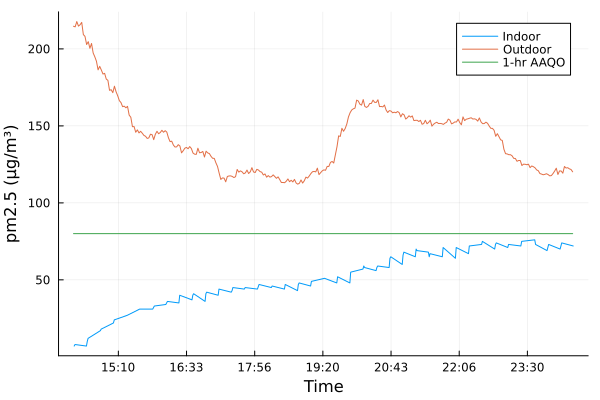

In [6]:
#| echo: false
#| label: fig-time-series
#| fig-cap: "Time series data for indoor and outdoor pm2.5 concentrations with the 1 hour AAQO indicated."

using Plots: plot, plot!

plot(indoor[!, :datetime], indoor[!, :meas], seriestype=:line, lab="Indoor")
plot!(outdoor[!, :DateTime], outdoor[!, :pm25], seriestype=:line, lab="Outdoor")
plot!([minimum(outdoor[!, :DateTime]), maximum(outdoor[!, :DateTime])], [80.0, 80.0], lab="1-hr AAQO")
plot!(xformatter= x -> Dates.format(DateTime(Dates.UTM(x)), "HH:MM"),
      ylabel="pm2.5 (μg/m³)", xlabel="Time", legend=:topright)

### Fitting the model

The type of fit I am doing is quite simple: I am fitting a differential equation to the *indoor* concentration while taking the *outdoor* concentration as a parameter of the model. Thus I need the outdoor concentration as a continuous function of time and, for simplicity, I am using a linear interpolation of the measured outdoor concentration.

In [7]:
using Interpolations: linear_interpolation, Flat

cₒ = linear_interpolation(outdoor.time, outdoor.pm25, extrapolation_bc=Flat());

To start, I define the differential equation that I am going to be fitting to the measured indoor concentration. This is the simple linear model for building infiltration
 
$$ {d \over dt} c = \lambda \left( c\_o - c \right) $$

Where *c* is the indoor concentration, *c*<sub>o</sub> the outdoor concentration, and *&lambda;* is the ventilation rate in units of h<sup>-1</sup>. 

In [8]:
#| output: false
using OrdinaryDiffEq

# the model
f(c, λ, t) = λ*(cₒ(t) - c)

# initial condition
c0 = indoor.meas[1]

# timespan
tspan = (0, indoor.time[end])

# parameters
p= [0.5] #initial guess of λ=0.5

prb = ODEProblem(f, c0, tspan, p)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 10.183333333333334)
u0: 7.0

Now I define the fit itself: with the cost function as the L2 loss between the measured indoor concentration and the predicted indoor concentration.

In [9]:
using DiffEqParamEstim: build_loss_objective, L2Loss

lossfn = L2Loss(indoor.time, indoor.meas)

cost_function = build_loss_objective(prb,Tsit5(),lossfn,
                                     maxiters=10000,verbose=false);

Then using the `Optim` package to find the parameter *&lambda;* which minimizes the cost function.

In [10]:
using Optim: optimize

result = optimize(cost_function, 0.0, 1.0)

Results of Optimization Algorithm
 * Algorithm: Brent's Method
 * Search Interval: [0.000000, 1.000000]
 * Minimizer: 7.848374e-02
 * Minimum: 1.517807e+03
 * Iterations: 35
 * Convergence: max(|x - x_upper|, |x - x_lower|) <= 2*(1.5e-08*|x|+2.2e-16): true
 * Objective Function Calls: 36

I can then retrieve the ventilation rate for my bedroom

In [11]:
λfit = result.minimizer[1]

0.07848373551388874

In [12]:
prb = ODEProblem(f, c0, tspan, λfit)
fit = solve(prb, Tsit5());

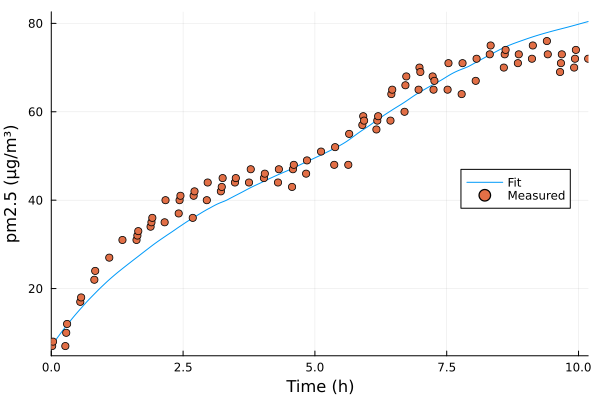

In [13]:
#| echo: false
#| label: fig-curve-fit
#| fig-cap: "Best fit curve for the simple linear building infiltration model."

plot(fit, seriestype=:line, lab="Fit")
plot!(indoor[!, :time], indoor[!, :meas], seriestype=:scatter, lab="Measured")
plot!(ylabel="pm2.5 (μg/m³)", xlabel="Time (h)", legend=:right)

I think this simple linear model works relatively well, all things considered. A more fulsome model would have treated the ventilation rate as a function of air pressure, windspeed, and the difference between indoor and outdoor temperatures.

There are also a few weaknesses in the experimental design, beyond the quality of the sensors. For one I didn't seal my door perfectly, and so there was some exchange with the rest of my apartment which had a much lower particulate concentration. I am also assuming that there is no deposition or adhesion of particulates when passing through the small leaks around my window. It's possible that some particulates are being lost along the way, which would impact this. The placement of sensors could also be an issue, especially the outdoor ones: I live in a neighbourhood full of large apartment buildings and that creates complex wind patterns, I also live several stories up whereas the purple air monitor is at ground level. A better location would have been on my balcony, adjacent to the bedroom window.

But I think as a first pass, and especially for screening potential shelter in place locations, something as simple as this could work and the time investment is very minimal. It's major weakness is that the key variable, the outdoor concentration, is not controlled and this whole exercise is dependent upon the whims of wildfire smoke and on the individuals responsiveness to smoke forecasts.

## Using a HEPA Filter

After all that time measuring how rapidly the particulates infiltrated a room, what is to be done? The air quality in Edmonton has been poor for several days on end. Without any sort of mitigation my bedroom would be well above the limits and would be unhealthly to be in and yet that's where I sleep. The solution is either installing furnace air filters with a high MERV rating or, in places like mine that lack central air, using a portable fan with a HEPA filter. I picked up [a portable air filter from IKEA](https://www.ikea.com/ca/en/p/starkvind-air-purifier-black-smart-40501967/) and similar ones are available from many places, and can be [made by hand](https://www.wikihow.com/Make-an-Air-Filter). Unfortunately, dangerously high levels of pm2.5s are invisible and generally undetectable to one's senses, so without some sort of monitoring one is left merely trusting that the system is doing what it is supposed to be doing. 

I tested my IKEA unit on Saturday night in a similar manner to the building infiltration test: I turned off the unit, closed my bedroom door, and left the space to accumulate particulates for several hours. Then, before I went to bed, I went in and turned it on. Throughout this the atmotube was located in the middle of the room collecting data. From the plot below it is clear that the air filter works: the indoor particulate concentration drops rapidly and stays at a low level throughout the night, even as the outdoor concentration rises to very high levels.

In [14]:
indoor_hepa = @pipe "data/C22B42153089_21_May_2023_10_05_00.csv" |>
                    CSV.read( _ , DataFrame; dateformat="yyyy-mm-dd HH:MM:SS");

outdoor_hepa = @pipe "data/21_May_2023_raw-pm25-gm.csv" |>
                     CSV.read( _ , DataFrame, dateformat="yyyy-mm-dd HH:MM:SS") |>
                     transform( _ , AsTable(["Purple Air A", "Purple Air B"]) => ByRow(mean) => :pm25);

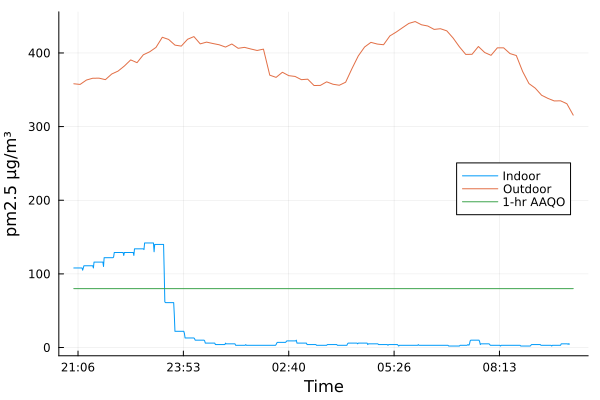

In [15]:
#| echo: false
#| label: fig-hepa
#| fig-cap: "Response of measured indoor particulate concentrations to air filtration. Note that the outdoor fine particulate concentration remains high throughout the measurement period."

plot(indoor_hepa[!, :Date], indoor_hepa[!, "PM2.5, ug/m3"], seriestype=:line, lab="Indoor")
plot!(outdoor_hepa[!, :DateTime], outdoor_hepa[!, "Purple Air A"], seriestype=:line, lab="Outdoor")
plot!([minimum(outdoor_hepa[!, :DateTime]), maximum(outdoor_hepa[!, :DateTime])], [80.0, 80.0], lab="1-hr AAQO")
plot!(xformatter= x -> Dates.format(DateTime(Dates.UTM(x)), "HH:MM"),
      ylabel="pm2.5 μg/m³", xlabel="Time", legend=:right)

## Final thoughts

Using wildfire smoke to measure the ventilation rates of different buildings, or rooms in buildings, is certainly a niche activity. I don't imagine there are many places where it is important to screen for safe shelter-in-place locations that also experience significant wildfire smoke events regularly. That does describe the petrochemical industry in Alberta, wildfire smoke is a regular occurrence now, and perhaps locations along the west coast, but it's not universal.

That said I wonder if this might be a more broadly useful activity when planning for how to manage indoor air quality beyond industry. The office building I work in struggles with indoor air quality during smoke events like this one whereas my home office does not because I have invested in HEPA filters and simple air monitoring. Perhaps schools, offices, and other places could use similar techniques to screen spaces for interventions. Rooms with high ventilation rates could benefit from interventions such as better sealing around windows. Perhaps the plastic sheeting used to seal drafty windows in the wintertime could find a second use during wildfire season. In this way the air filters themselves are being used more effectively: an air filter can manage a larger space if that space has a low ventilation rate.

Currently a lot of the advice is merely to stay indoors, with little acknowledgment that indoors is often severely polluted as well.